# Behavior tree toys and examples

Just a scribble notebook of examples of Using behavior Trees.

I strongly recommend looking at Daniel Stonier's reading list provided in the py_tree introduction. Especially the talk link, though it gets very technical. Easy to watch while working.

https://py-trees.readthedocs.io/en/devel/introduction.html

1. https://roboticseabass.com/2021/05/08/introduction-to-behavior-trees/
1. https://www.youtube.com/watch?v=n4aREFb3SsU

His tutorial overall is really good. 


In [15]:
import py_trees

# https://stackoverflow.com/questions/4596962/display-graph-without-saving-using-pydot/18522941
from IPython.display import Image, display
def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

In [16]:
py_trees.version.__version__

'2.1.1'

I am creating Toy Behaviors from the sample primitives provided by Daniel in the py_trees libraries.
Let's start with a simple reactive car. It will drive in it's lane unless the ego car is near.


I'll invent a few behaviors.
DriveInLane: Car will follow its current lane and never change langes.
IsEgoCarNear: Returns SUCCESS (i.e. True) if Ego is near
BlockEgoCar: Drive in lane while keeping a fixed relative offset to the ego car (i.e. drive right next to it)

In [17]:
# Returns running basically forever. Never finishes its work.
drive_in_lane = py_trees.behaviours.Count(name="DriveInLane", fail_until=0, running_until=1000, reset=False)

# Emulates the ego getting near after 2 ticks.
ego_is_near = py_trees.behaviours.Count(name="EgoIsNear", fail_until=2, running_until=0, success_until=100, reset=False)

# Emulates blocking the ego.
block_ego = py_trees.behaviours.Count(name="BlockEgo", fail_until=0, running_until=1000, reset=False) 

# Set these behaviors up in a "Tree" with two branches.
selector = py_trees.composites.Selector(name="DriveOrBlock")

# Block only occurs if the condition behavior is True, so we put it in a sequence. 
sequence = py_trees.composites.Sequence(name="BlockIfEgoNear")
sequence.add_children([ego_is_near, block_ego])
selector.add_child(sequence)

# Drive is by itself as a child of the selector.
selector.add_child(drive_in_lane)



# We create a tree wrapper, which gives us some niceities.
tree = py_trees.trees.BehaviourTree(root=selector)
tree.setup()

In [18]:
print("{}".format(py_trees.display.ascii_tree(selector)))

[o] DriveOrBlock
    [-] BlockIfEgoNear
        --> EgoIsNear
        --> BlockEgo
    --> DriveInLane



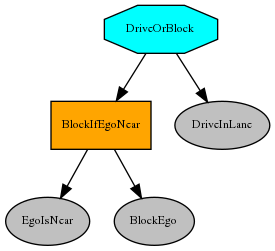

In [19]:
# We've got nicer renderers.
view_pydot(py_trees.display.dot_tree(selector))

In [20]:
tree.tick()
print("{}".format(py_trees.display.ascii_tree(selector, show_status=True)))

[o] DriveOrBlock [*]
    [-] BlockIfEgoNear [x]
        --> EgoIsNear [x]
        --> BlockEgo [-]
    --> DriveInLane [*] -- running



After one tick, the EgoIsNear is failing, so we are driving in lane. After 3 ticks, it becomes true.

In [21]:
for index in range(3):
    tree.tick()
print("{}".format(py_trees.display.ascii_tree(selector, show_status=True)))

[o] DriveOrBlock [*]
    [-] BlockIfEgoNear [*]
        --> EgoIsNear [o]
        --> BlockEgo [*] -- running
    --> DriveInLane [-]



Now the agent would block the Ego car. Each of these behaviors is of course trivial, but it gets rather complex quickly. Each behavior can be extremely complex. Or, such complexity can be abstracted out across many behaviors that run in sequence. 

You can imagine composing these behaviors as well. We could use a behavior to apply the control commands back to the simulator after computing them. So, DriveInLane becomes
1. Compute commands to drive along lane.
1. Apply controls to sim.

The choice to block the ego is a new layer in the middle.
1. Compute commands to drive along lane.
1. If ego is close enough, modify those controls to block.
1. Apply controls to sim.

This takes the rough shape of the following tree.

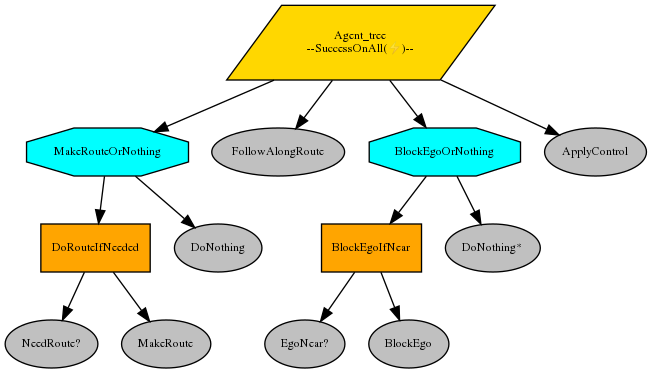

In [22]:
need_new_route = py_trees.behaviours.Success(name="NeedRoute?")
make_route = py_trees.behaviours.Success(name="MakeRoute")
follow_route = py_trees.behaviours.Success(name="FollowAlongRoute")
ego_near = py_trees.behaviours.Success(name="EgoNear?")
block_ego = py_trees.behaviours.Success(name="BlockEgo")
do_nothing = py_trees.behaviours.Success(name="DoNothing")
do_nothing2 = py_trees.behaviours.Success(name="DoNothing")
apply_control = py_trees.behaviours.Success(name="ApplyControl")

# Nasty way to make a tree, but an example of how it can be done
root_node = py_trees.composites.Parallel(
    "Agent_tree", children=[
        py_trees.composites.Selector(
            "MakeRouteOrNothing", children=[
                py_trees.composites.Sequence(
                    "DoRouteIfNeeded", children=[need_new_route, make_route]
                ),
                do_nothing
            ]
        ),
        follow_route,
        py_trees.composites.Selector(
            "BlockEgoOrNothing", children=[
                py_trees.composites.Sequence(
                    "BlockEgoIfNear", children=[ego_near, block_ego]
                ),
                do_nothing2
            ]
        ),
        apply_control
    ]
)
view_pydot(py_trees.display.dot_tree(root_node))

One more detail worth discussing in PyTrees is the blackboard. Think of the blackboard as a global data store that houses information that needs to be shared between nodes. An old classic behavior tree example is the dragon hoarding gold. I'll use that to demonstrate the blackboard.

Consider a dragon hoarding its gold from heroes. The dragon should
1) snuggle its hoard.
1) attack heroes that get close.
1) flee if it is injured until it recovers.

We can code a toy tree for this (and I do so below). I am using some basic behaviors which access blackboard data and return based on conditions. In a real example, we could subclass these and hide the complexity.

In [23]:
# Make an accessor and set the dragon's health to 10 and the distance to a hero to 10.
# Pytrees allows us to register a client for specific variables as a method of access control. Additionally all
# behaviors have a client created for them automatically.
blackboard_client = py_trees.blackboard.Client(name="dragon")
blackboard_client.register_key("dragon_health", access=py_trees.common.Access.WRITE)
blackboard_client.register_key("hero_distance", access=py_trees.common.Access.WRITE)
blackboard_client.dragon_health = 10
blackboard_client.hero_distance = 10

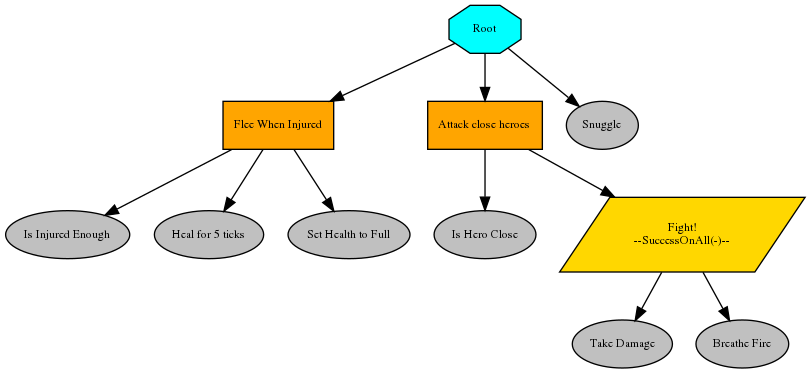

In [27]:
import operator

# Now we can make our tree.

##################################################
##### Fleeing when injured is the highest priority.
##################################################
flee_sequence = py_trees.composites.Sequence("Flee When Injured")
check_is_injured = py_trees.behaviours.CheckBlackboardVariableValue(
    name="Is Injured Enough",
    check=py_trees.common.ComparisonExpression(
        variable="dragon_health",
        value=5,
        operator=operator.lt
    )
)
wait_while_healing = py_trees.behaviours.TickCounter(name="Heal for 5 ticks", duration=5)
heal = py_trees.behaviours.SetBlackboardVariable(
    name="Set Health to Full",
    variable_name="dragon_health",
    variable_value=10
)
flee_sequence.add_children([check_is_injured,wait_while_healing,heal])

###############################################################
##### Attacking nearby heros is the next highest priority task.
###############################################################
hero_sequence = py_trees.composites.Sequence("Attack close heroes")
check_hero_close = py_trees.behaviours.CheckBlackboardVariableValue(
    name="Is Hero Close",
    check=py_trees.common.ComparisonExpression(
        variable="hero_distance",
        value=5,
        operator=operator.le
    )
)
fight_hero_parallel = py_trees.composites.Parallel(
    name="Fight!",
    # Synchronise False will cause each child to tick each tick until all children return SUCCESS. 
    # Children which return SUCCESS will be restarted.
    policy=py_trees.common.ParallelPolicy.SuccessOnAll(synchronise=False)
)
take_damage = py_trees.behaviours.SetBlackboardVariable(
    name="Take Damage",
    variable_name="dragon_health",
    variable_value=lambda: blackboard_client.get("dragon_health") - 1
)
run_forever = py_trees.behaviours.Running("Breathe Fire")
fight_hero_parallel.add_children([take_damage, run_forever])
hero_sequence.add_children([check_hero_close, fight_hero_parallel])

###############################################################
##### If there are no heroes to fight, snuggle the hoard!
###############################################################
snuggle = py_trees.behaviours.Running(name="Snuggle")

# Root selector.
root = py_trees.composites.Selector("Root", children=[flee_sequence, hero_sequence, snuggle])
tree = py_trees.trees.BehaviourTree(root=root)
tree.setup()
view_pydot(py_trees.display.dot_tree(root))

In [28]:
# Our dragon will snuggle its hoard by default.
tree.tick()
print("{}".format(py_trees.display.ascii_tree(root, show_status=True)))

[o] Root [*]
    [-] Flee When Injured [x]
        --> Is Injured Enough [x] -- 'dragon_health' comparison failed [v: 10][e: 5]
        --> Heal for 5 ticks [-]
        --> Set Health to Full [-]
    [-] Attack close heroes [x]
        --> Is Hero Close [x] -- 'hero_distance' comparison failed [v: 10][e: 5]
        [||] Fight! [-]
            --> Take Damage [-]
            --> Breathe Fire [-]
    --> Snuggle [*] -- running



In [29]:
# If we bring a hero close enough, the dragon attacks.
blackboard_client.hero_distance = 5
tree.tick()
print("{}".format(py_trees.display.ascii_tree(root, show_status=True)))

[o] Root [*]
    [-] Flee When Injured [x]
        --> Is Injured Enough [x] -- 'dragon_health' comparison failed [v: 10][e: 5]
        --> Heal for 5 ticks [-]
        --> Set Health to Full [-]
    [-] Attack close heroes [*]
        --> Is Hero Close [o] -- 'hero_distance' comparison succeeded [v: 5][e: 5]
        [||] Fight! [*]
            --> Take Damage [o]
            --> Breathe Fire [*] -- running
    --> Snuggle [-]



In [30]:
# If we let the dragon fight for 6 more framees, they will flee as the hero has done too much damage.
tree.tick()
tree.tick()
tree.tick()
tree.tick()
tree.tick()
tree.tick()
print("{}".format(py_trees.display.ascii_tree(root, show_status=True)))

[o] Root [*]
    [-] Flee When Injured [*]
        --> Is Injured Enough [o] -- 'dragon_health' comparison succeeded [v: 4][e: 5]
        --> Heal for 5 ticks [*]
        --> Set Health to Full [-]
    [-] Attack close heroes [-]
        --> Is Hero Close [-] -- 'hero_distance' comparison succeeded [v: 5][e: 5]
        [||] Fight! [-]
            --> Take Damage [-]
            --> Breathe Fire [-]
    --> Snuggle [-]



In [31]:
# Assuming the hero runs. In a few more frames, our dragon is good as new. This tree return SUCCESS in this case.
blackboard_client.hero_distance = 10
tree.tick()
tree.tick()
tree.tick()
tree.tick()
tree.tick()
print("{}".format(py_trees.display.ascii_tree(root, show_status=True)))

[o] Root [o]
    [-] Flee When Injured [o]
        --> Is Injured Enough [o] -- 'dragon_health' comparison succeeded [v: 4][e: 5]
        --> Heal for 5 ticks [o]
        --> Set Health to Full [o]
    [-] Attack close heroes [-]
        --> Is Hero Close [-] -- 'hero_distance' comparison succeeded [v: 5][e: 5]
        [||] Fight! [-]
            --> Take Damage [-]
            --> Breathe Fire [-]
    --> Snuggle [-]



Behavior Trees create an easy to follow code flow and are extremely easy to debug. We can see each tick exactly what the agents were trying to do, and analyze what went wrong. We can also wrap deep-learned models in a behaviour and use them in line with rule based models.
